## Prepare Packages

In [83]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


## Import model (Policy and TiDE)

In [84]:
from policy import PolicyNN
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model.load_state_dict(torch.load("policy_model_0702_allloss_3L_1024H_s1_c0.pth", map_location="cpu"))
# model.load_state_dict(torch.load("policy_model_0630_onlytracking_3L_1024H.pth", map_location="cpu"))

<All keys matched successfully>

In [85]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())



## Run Initial Gamma

In [86]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

print("init_avg shape:", init_avg.shape)

mins, _ = init_avg.min(dim=1)  
maxs, _ = init_avg.max(dim=1)  

for i, (mn, mx) in enumerate(zip(mins, maxs), start=1):
    print(f"Element {i}: min = {mn.item()}, max = {mx.item()}")

100%|██████████| 250/250 [00:05<00:00, 45.26it/s]

init_avg shape: torch.Size([2, 50])
Element 1: min = 400.0, max = 2479.916748046875
Element 2: min = -0.5510203838348389, max = 0.0


## Import reference data

In [87]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)

# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)

# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

print("laser_power_past shape:", laser_power_past.shape)
print("fix_covariates shape:", fix_covariates.shape)
print("mp_temp_ref shape:", mp_temp_ref.shape)


laser_power_past shape: torch.Size([50, 1])
fix_covariates shape: torch.Size([6295, 3])
mp_temp_ref shape: torch.Size([6295])


In [88]:
import torch

# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


In [89]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [ ]:
if init_avg.shape == (2, 50):
    init_avg = init_avg.T # shape : [50, 2]
    
init_avg = init_avg.to(device)  # shape: [50, 2]
fix_covariates = fix_covariates.to(device)    # shape: [6295, 3]
mp_temp_ref    = mp_temp_ref   .to(device)    # shape: [6295]
laser_power_past_flat = laser_power_past.squeeze(-1).to(device)  # shape: [50]



fix_cov_norm = torch.stack(
    [normalize_x(fix_covariates[:, d], dim_id=d) for d in range(fix_covariates.shape[1])],
    dim=1
).to(device)

laser_power_past_norm = normalize_x(laser_power_past_flat, dim_id=3).unsqueeze(-1)
mp_temp_ref_norm = normalize_y(mp_temp_ref, dim_id=0).unsqueeze(-1)
init_avg_norm = normalize_y(init_avg, dim_id=0)

print("fix_cov_norm shape:", fix_cov_norm.shape)
print("mp_temp_ref_norm shape:", mp_temp_ref_norm.shape)
print("laser_power_past_norm shape:", laser_power_past_norm.shape)
print("init_avg_norm shape:", init_avg_norm.shape)


fix_cov_norm shape: torch.Size([6295, 3])
mp_temp_ref_norm shape: torch.Size([6295, 1])
laser_power_past_norm shape: torch.Size([50, 1])
init_avg_norm shape: torch.Size([50, 2])


In [91]:
depth_const = torch.tensor([[0.4126, 0.1423]], dtype=torch.float32, device=device)
depth_const_s = normalize_y(depth_const, dim_id=[1])
upper_line = depth_const_s[0, 0].item()
lower_line = depth_const_s[0, 1].item()
depth_flat    = depth_const_s.view(-1)                # [2]
depth_repeat  = depth_flat.unsqueeze(0).unsqueeze(1).repeat(1, window, 1)  # [1, 50, 2]
c_input       = depth_repeat

In [102]:
print("init_avg shape (y[0,1]):", init_avg.shape)
print("laser_power_past_norm shape (x[3]):", laser_power_past_norm.shape)
print("fix_cov_norm shape (x[0,1,2]):", fix_cov_norm.shape)
print("mp_temp_ref_norm shape (y[0]):", mp_temp_ref_norm.shape)
print("depth_const_s shape:", c_input.shape)


init_avg shape (y[0,1]): torch.Size([50, 2])
laser_power_past_norm shape (x[3]): torch.Size([50, 1])
fix_cov_norm shape (x[0,1,2]): torch.Size([6295, 3])
mp_temp_ref_norm shape (y[0]): torch.Size([6295, 1])
depth_const_s shape: torch.Size([1, 50, 2])


In [104]:
# fix_cov_norm: [6295, 3]
print("=== fix_cov_norm (x[0,1,2]) ===")
for i in range(fix_cov_norm.shape[1]):
    col = fix_cov_norm[:, i]
    print(f" feature {i:1d}: min = {col.min().item(): .4f}, max = {col.max().item(): .4f}")

# laser_power_past_norm: [50, 1]
print("\n=== laser_power_past_norm (x[3]) ===")
col = laser_power_past_norm.squeeze(-1)
print(f" feature 3:       min = {col.min().item(): .4f}, max = {col.max().item(): .4f}")

# init_avg: [50, 2]
print("\n=== init_avg (y[0,1]) ===")
for i in range(init_avg_norm.shape[1]):
    col = init_avg_norm[:, i]
    print(f" feature {i:1d}: min = {col.min().item(): .4f}, max = {col.max().item(): .4f}")

# mp_temp_ref_norm: [6295, 1]
print("\n=== mp_temp_ref_norm (y[0]) ===")
col = mp_temp_ref_norm.squeeze(-1)
print(f" feature 0:       min = {col.min().item(): .4f}, max = {col.max().item(): .4f}")

# depth_const_s (constraint): c_input is [1,50,2]
depth = c_input.squeeze(0)  # [50,2]
print("\n=== depth_const_s (constraint) ===")
for i in range(depth.shape[1]):
    col = depth[:, i]
    print(f" feature {i:1d}: min = {col.min().item(): .4f}, max = {col.max().item(): .4f}")


=== fix_cov_norm (x[0,1,2]) ===
 feature 0: min = -1.0000, max =  1.0000
 feature 1: min = -1.0000, max =  1.0000
 feature 2: min = -1.0000, max =  1.0000

=== laser_power_past_norm (x[3]) ===
 feature 3:       min = -0.7405, max = -0.7396

=== init_avg (y[0,1]) ===
 feature 0: min = -1.0180, max =  0.0033
 feature 1: min = -1.2146, max = -1.2144

=== mp_temp_ref_norm (y[0]) ===
 feature 0:       min =  nan, max =  nan

=== depth_const_s (constraint) ===
 feature 0: min =  0.7506, max =  0.7506
 feature 1: min =  0.2636, max =  0.2636


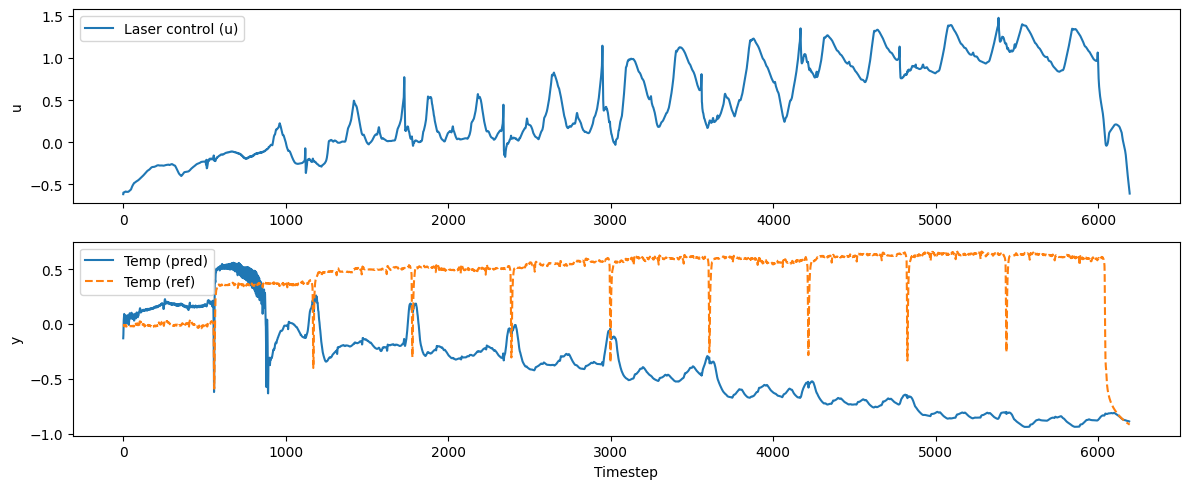

In [111]:
import torch
import matplotlib.pyplot as plt

# --- 설정 ---
data_device = fix_cov_norm.device

policy_model = model.to(data_device)
TiDE         = TiDE.to(data_device)

window = 50

# 이미 준비된 정규화된 텐서들 (모두 device 위에 있다고 가정)
# init_avg              → torch.Size([50, 2])
# laser_power_past_norm → torch.Size([50, 1])
# fix_cov_norm          → torch.Size([6295, 3])
# mp_temp_ref_norm      → torch.Size([6295, 1])
# c_input               → torch.Size([1, 50, 2])  # constraint for current window

init_avg_norm         = init_avg_norm.to(device)           # [50,2]
laser_hist            = laser_power_past_norm.to(device)   # [50,1]
fix_cov_norm          = fix_cov_norm.to(device)            # [6295,3]
mp_temp_ref_norm      = mp_temp_ref_norm.to(device)        # [6295,1]
c_input               = c_input.to(device)                 # [1,50,2]

model.eval()
TiDE.eval()

us_save = []
ys_save = []

# 총 반복 스텝 수
num_steps = fix_cov_norm.shape[0] - 2*window + 1

# y 히스토리 초기화
y_hist = init_avg_norm  # [50,2]

for t in range(num_steps):
    # 1) 과거 입력 (t ~ t+49)
    x_past_cov  = fix_cov_norm[t : t+window]                              # [50,3]
    x_past_full = torch.cat((x_past_cov, laser_hist), dim=1).unsqueeze(0) # [1,50,4]
    y_past      = y_hist.unsqueeze(0)                                     # [1,50,2]

    # 2) 미래 입력 (t+50 ~ t+99)
    start = t + window
    end   = t + 2*window
    x_fut_cov = fix_cov_norm[start : end].unsqueeze(0)                    # [1,50,3]
    ref_fut   = mp_temp_ref_norm[start : end].unsqueeze(0)                # [1,50,1]
    c_fut     = c_input                                                  # [1,50,2]

    # 3) Policy 예측
    policy_in_past   = torch.cat((x_past_full, y_past), dim=2)            # [1,50,6]
    policy_in_future = torch.cat((x_fut_cov, ref_fut, c_fut), dim=2)     # [1,50,6]
    with torch.no_grad():
        u_fut = model((policy_in_past, policy_in_future))                # [1,50,1]
    u = u_fut[0,0,0].item()
    us_save.append(u)

    # laser 히스토리 슬라이드
    laser_hist = torch.cat((laser_hist[1:], torch.tensor([[u]], device=device)), dim=0)  # [50,1]

    # 4) TiDE 예측
    x_future_tide = torch.cat((x_fut_cov, u_fut), dim=2)                   # [1,50,4]
    past_cov      = torch.cat((y_past, x_past_full), dim=2)                # [1,50,6]
    with torch.no_grad():
        y_pred = TiDE((past_cov, x_future_tide, None))                    # [1,50,2,3]

    # 가운데값 선택: batch=0, time=0, features=all, index=1
    y_step = y_pred[0, 0, :, 1]                                            # [2]
    ys_save.append(y_step.cpu().numpy())

    # y 히스토리 슬라이드
    y_hist = torch.cat((y_hist[1:], y_step.unsqueeze(0)), dim=0)           # [50,2]

# --- reference 시퀀스 준비 ---
mp_ref   = mp_temp_ref_norm.squeeze(-1)          # 아직 GPU 위
ref_save = mp_ref[window : window + len(us_save)]  # slice 후에도 GPU

# CPU로 옮기고 numpy
ref_save = ref_save.detach().cpu().numpy()       # → 1D numpy array

# plot 용 데이터도 모두 numpy 로 변환
us_np   = us.cpu().numpy()
ys_np   = ys.cpu().numpy()
time_np = time.cpu().numpy()

# --- 결과 플롯 ---
plt.figure(figsize=(12,5))

plt.subplot(2,1,1)
plt.plot(time_np, us_np, label="Laser control (u)")
plt.ylabel("u"); plt.legend()

plt.subplot(2,1,2)
plt.plot(time_np, ys_np[:,0], label="Temp (pred)")
plt.plot(time_np, ref_save, label="Temp (ref)", linestyle="--")
plt.xlabel("Timestep"); plt.ylabel("y"); plt.legend()

plt.tight_layout()
plt.show()

